In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import json
%matplotlib inline
import netwulf as nw
plt.style.use('seaborn-white')

master = pd.read_csv('final_data_set.csv', sep = ';', encoding = 'utf-8')

# Netwulf kan ikke finde ud af Nan
master = master.dropna(subset=["laureate_name", "affiliation"])

In [93]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
G_bi = nx.Graph()
G_bi.add_nodes_from(master["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(master["affiliation"], bipartite = 1)
edge_list = list(master[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

# Bipartite Laureate to Affiliation

In [ ]:
''' Only if the configs seem off '''
#Use netwulf to visualize
# network, config = nw.visualize(G_bi, plot_in_cell_below=False)

In [10]:
''' Save configs if necesarry '''
# with open('nx_configs/overall_bipartite.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

NameError: name 'config' is not defined

In [97]:
import netwulf as nw
plt.style.use('seaborn-white')

with open('nx_configs/overall_bipartite.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

In [98]:
''' Recolor nodes based on a partition dictionary and colormap 
    Only works if all nodes in nx_configs are in partition_dict as well '''

def redefine_attr(nx_configs, partition_dict, _sort = False , _cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib
    import random
    ''' Using The sort parameter, you can reference at dict to sort the attributes by,
    where the dicts keys is the attribute, and the dicts value represents some order '''
    
    if _sort:
        _keys = sorted(set(partition_dict.values()), key = lambda x: _sort[x], reverse = True)
    else:
        _keys = list(set(partition_dict.values())) # the attribute classes
        random.shuffle(_keys) # shuffle order - 
        
    n_keys = len(_keys) # how many are there? how many colors do we need?
    # assign each attribute class a unique value between 0 and 1
    # _num/(n_keys-1) --> standarize score with 0 and 1 as min and max
    attr_scale_dict = {_cat:_num/(n_keys-1) for _cat, _num in zip(_keys, range(n_keys))}

    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(nx_configs)
    
    for node_nr in range(len(nx_configs['nodes'])):
        node = nx_configs['nodes'][node_nr]['id'] # node id 
        attr = partition_dict[node] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color) 
        
    return new_nw

# set colormap of the plot 
network = redefine_attr(network, node_attr)

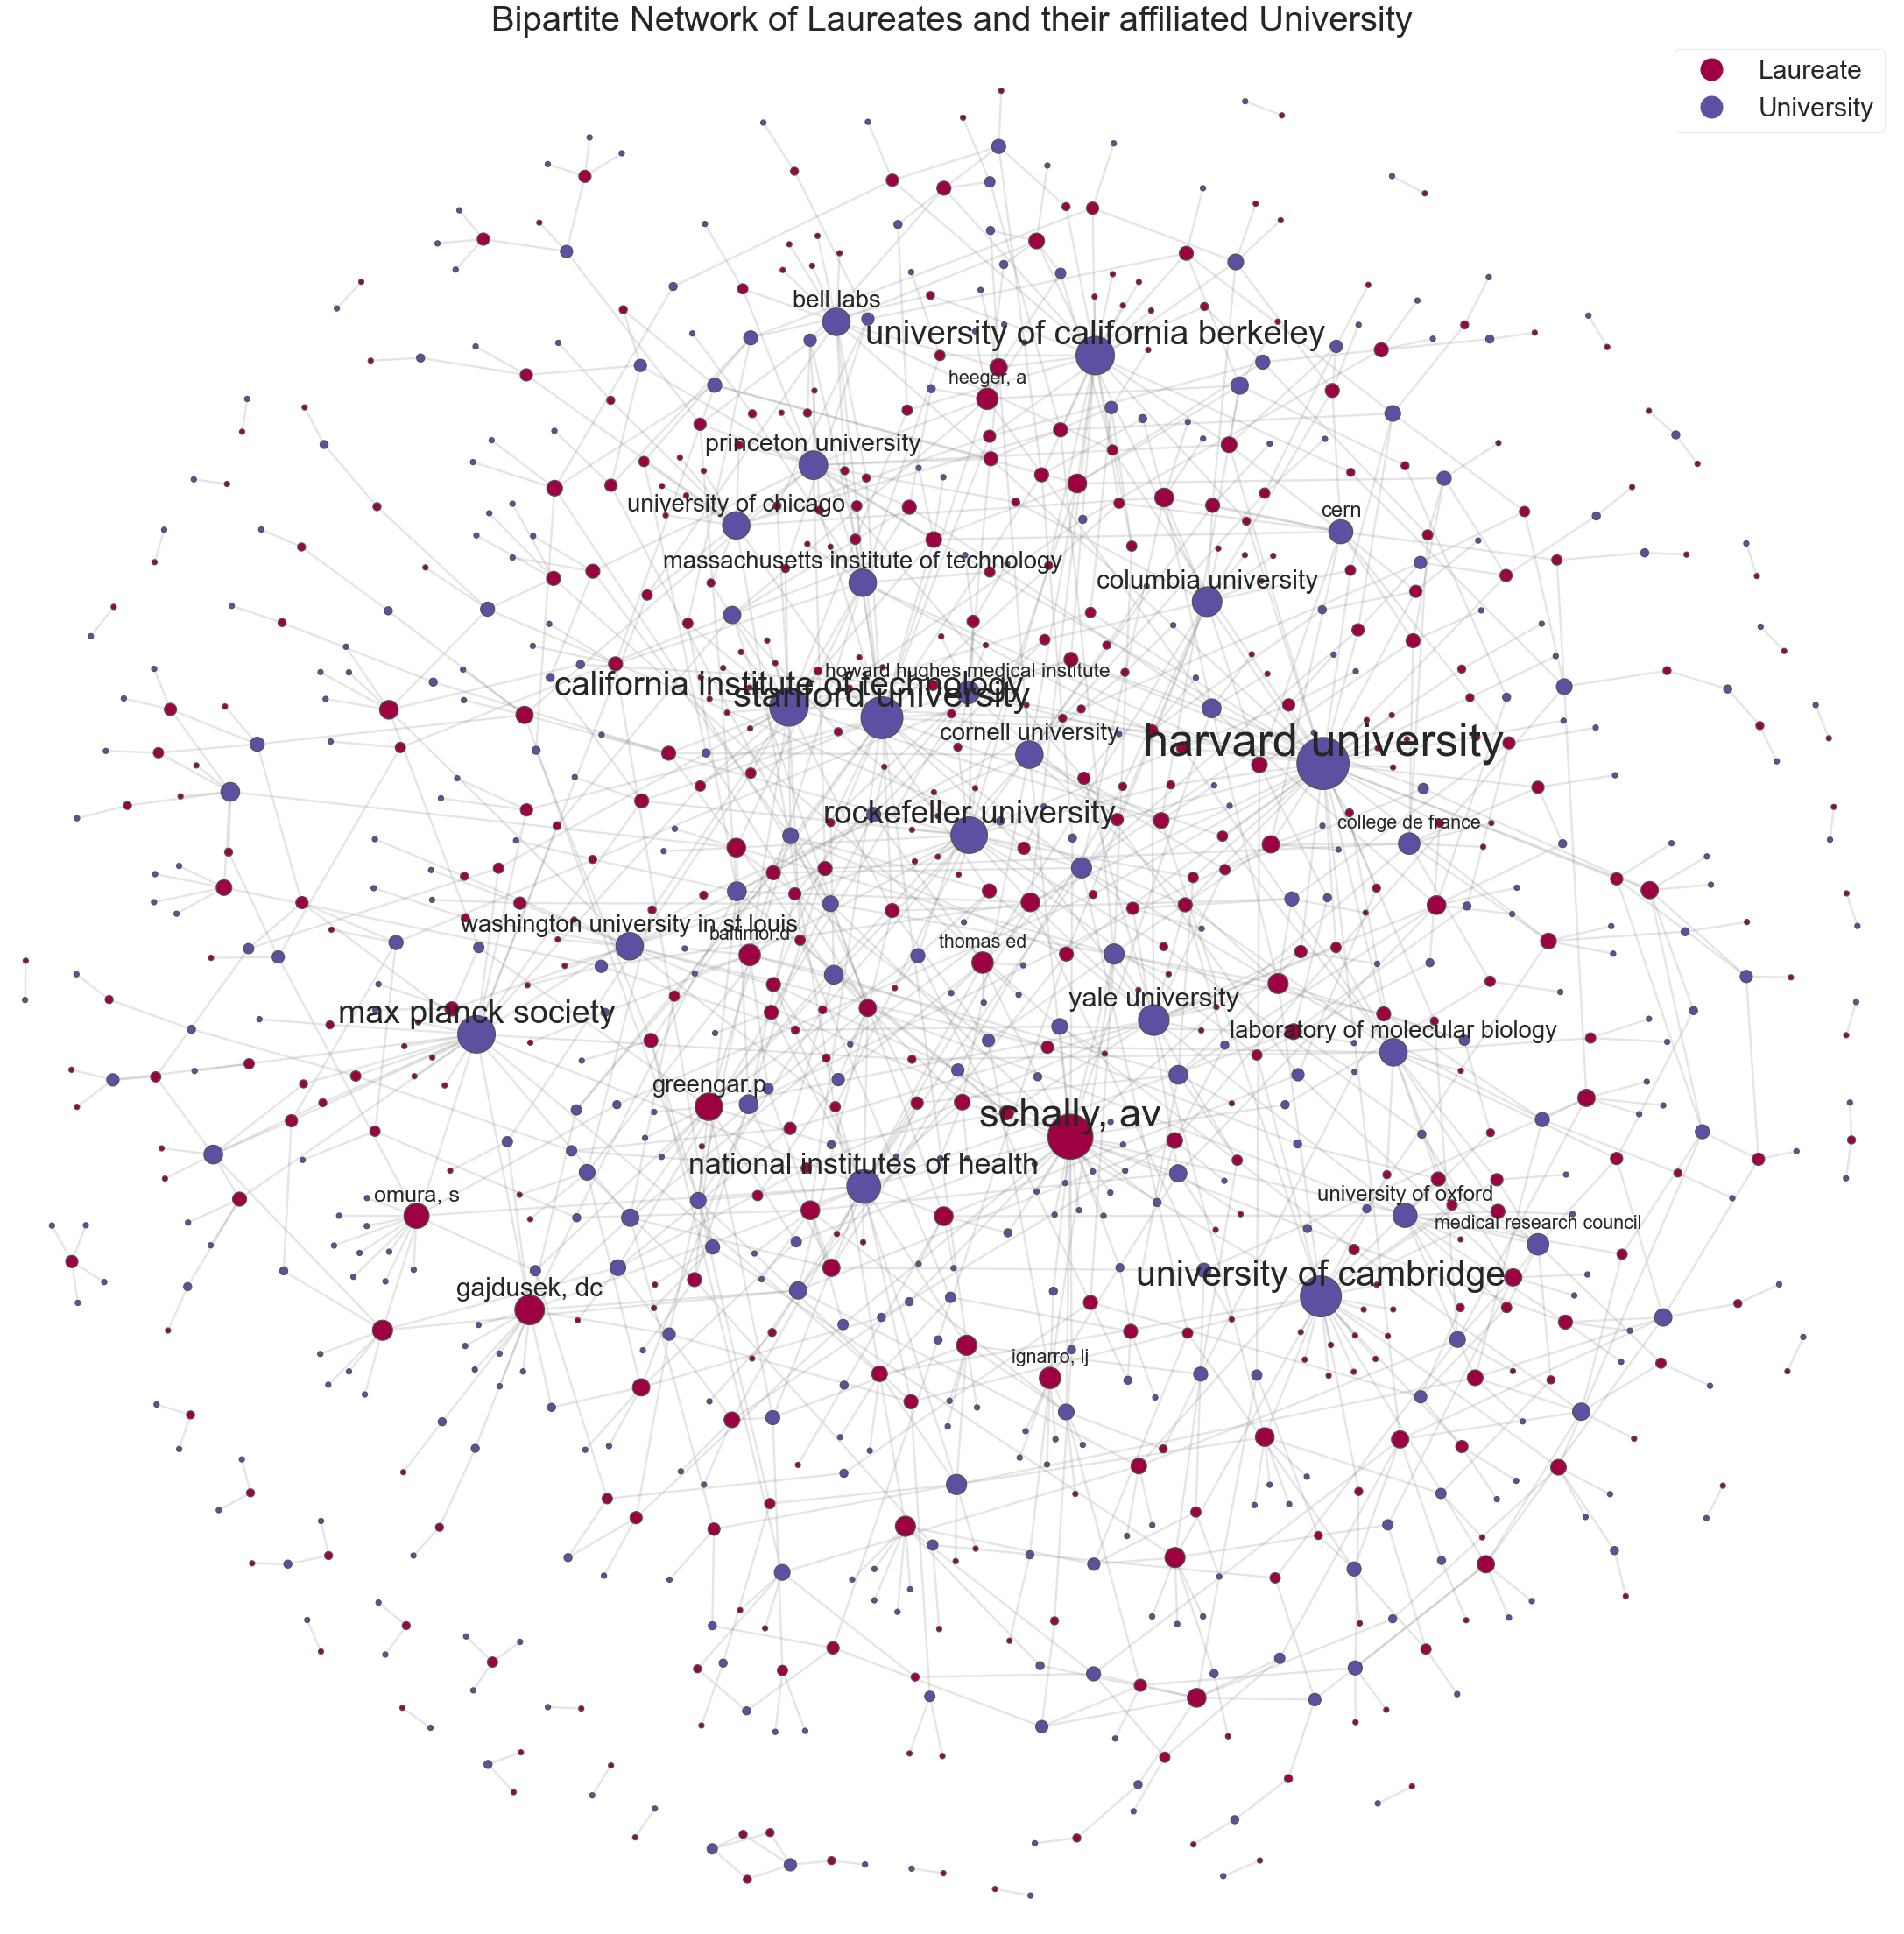

In [99]:
# set colormap of the plot 
network = redefine_attr(network, node_attr)

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

fig, ax = nw.draw_netwulf(network)

# Dict to assign labels to the plot 
laureate_dict = dict.fromkeys(master["laureate_name"], "Laureate")
university_dict = dict.fromkeys(master["affiliation"], "University")
laureate_dict.update(university_dict)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>6: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*3.5)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 25)

plt.legend(fontsize = 30, frameon=True)
plt.title('Bipartite Network of Laureates and their affiliated University', size = 40)

# Saving as pdf
plt.savefig('Plots/bipartite_laureate_uni.', dpi=None, facecolor='w', edgecolor='w')

In [100]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(G=None, top_n = 50, hue_name = None ,hue_dict = None):
    
    _df = pd.DataFrame(sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n],
                       columns = ['Name','count'])

    _df[hue_name] = _df.Name.apply(lambda x: hue_dict[x])
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(data = _df, x='Name', y='count', hue = hue_name, palette = "deep",ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    ax.set_title(f'Degree distribution for top {top_n} node', size = 15)
    return fig

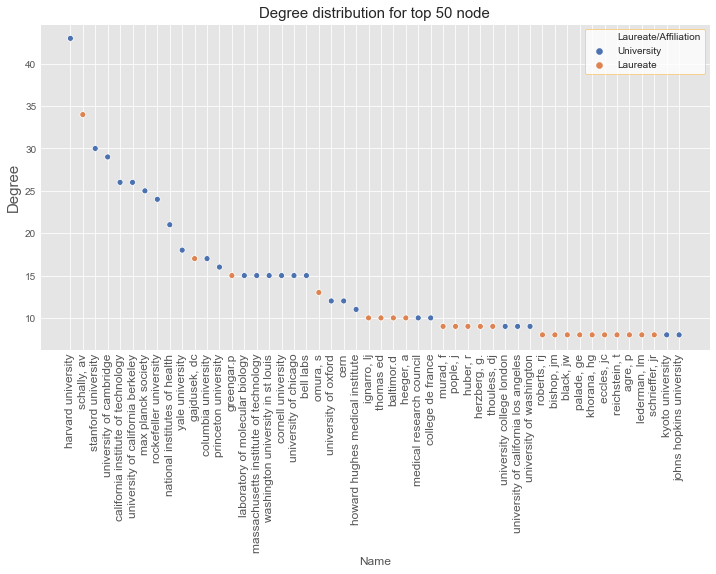

In [102]:
plt.style.use('ggplot')
f = plot_top_nodes(G=G_bi,
                   hue_name = 'Laureate/Affiliation',
                   hue_dict = laureate_dict)

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
f.savefig('Plots/top_connected.', dpi=None, facecolor='w', edgecolor='w', bbox_inches="tight")

## Degree Distribution

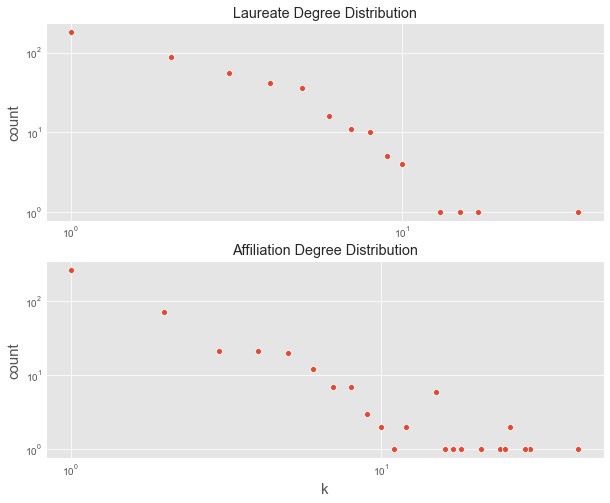

In [45]:
plt.style.use('ggplot')
lau_deg_dist = pd.Series([G_bi.degree()[n] for n,attr in G_bi.nodes(data=True) if\
                          attr['bipartite'] == 0]).value_counts()
uni_deg_dist = pd.Series([G_bi.degree()[n] for n,attr in G_bi.nodes(data=True) if\
                          attr['bipartite'] == 1]).value_counts()

fig, ax = plt.subplots(2,1, figsize=(10,8))

sns.scatterplot(x=lau_deg_dist.index, y=lau_deg_dist, ax = ax[0])
sns.scatterplot(x=uni_deg_dist.index, y=uni_deg_dist, ax = ax[1])

ax[0].set_title('Laureate Degree Distribution')
ax[0].set_ylabel('count', size = 15)
ax[1].set_title('Affiliation Degree Distribution')
ax[1].set_ylabel('count', size = 15)
ax[1].set_xlabel('k', size = 15)
# logscale the axes
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

## Projection of Bipartite Network

In [103]:
## Split into projections 
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

## Laurate projection with Nationality 

In [104]:
''' Nationality hue for laureates '''
master.nationality = master.nationality.apply(lambda x: x.split(',')[0])
master.nationality = master.nationality.apply(lambda x: x.split('-')[0])
name_nat_dict = {name:nat for name, nat in zip(master.laureate_name, master.nationality)}

# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')

In [ ]:
''' Only if the configs seem off '''
#Use netwulf to visualize
# network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

In [52]:
''' Save configs if necesarry '''
# with open('nx_configs/lau_bipartite.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

In [105]:
with open('nx_configs/lau_bipartite.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False, config = config)


network = redefine_attr(network, name_nat_dict) # colormap it

In [48]:
''' Hvis der skal sorteres '''
# from collections import Counter
# _size = dict(Counter([attr['group'] for n, attr in dict(G_top_pro.nodes(data=True)).items()]))
# network = redefine_attr(network, name_nat_dict, _sort = _size)

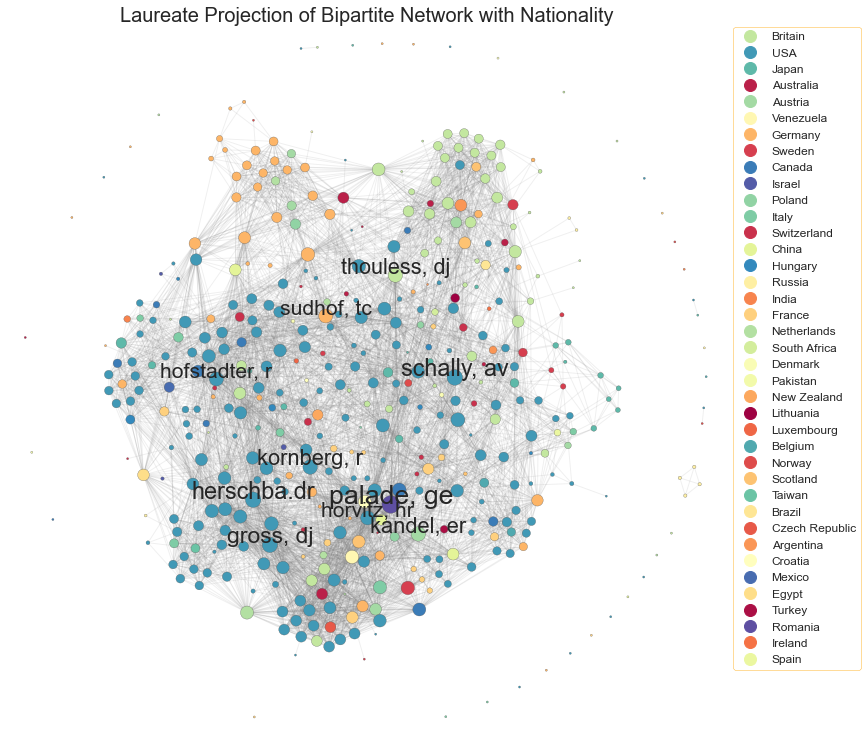

In [114]:
# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

fig, ax = nw.draw_netwulf(network, figsize = 10)
ax.set_title('Laureate Projection of Bipartite Network with Nationality', size = 20)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>10.5: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass


val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
legend = plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12, frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
plt.savefig('Plots/laureate_projection_nationality.png', dpi=200, bbox_inches='tight')

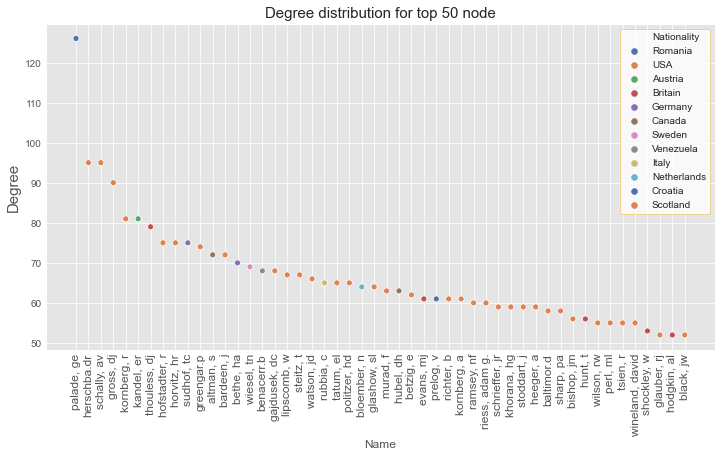

In [111]:
f = plot_top_nodes(G=G_top_pro,
                   hue_name = 'Nationality',
                   hue_dict = name_nat_dict)

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
f.savefig('Plots/top_connected_laureate_bipart.png', dpi=None, facecolor='w', edgecolor='w',
         bbox_inches="tight")

### University Projection

In [115]:
import netwulf as nw
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(master.affiliation, master.uni_nationality)}
# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')

In [66]:
#Use netwulf to visualize
# network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

In [67]:
''' Save configs if necesarry '''
# with open('nx_configs/org_bipartite.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

In [116]:
with open('nx_configs/org_bipartite.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, nat_dict) # colormap it

<ipython-input-118-3f68203e6be6>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


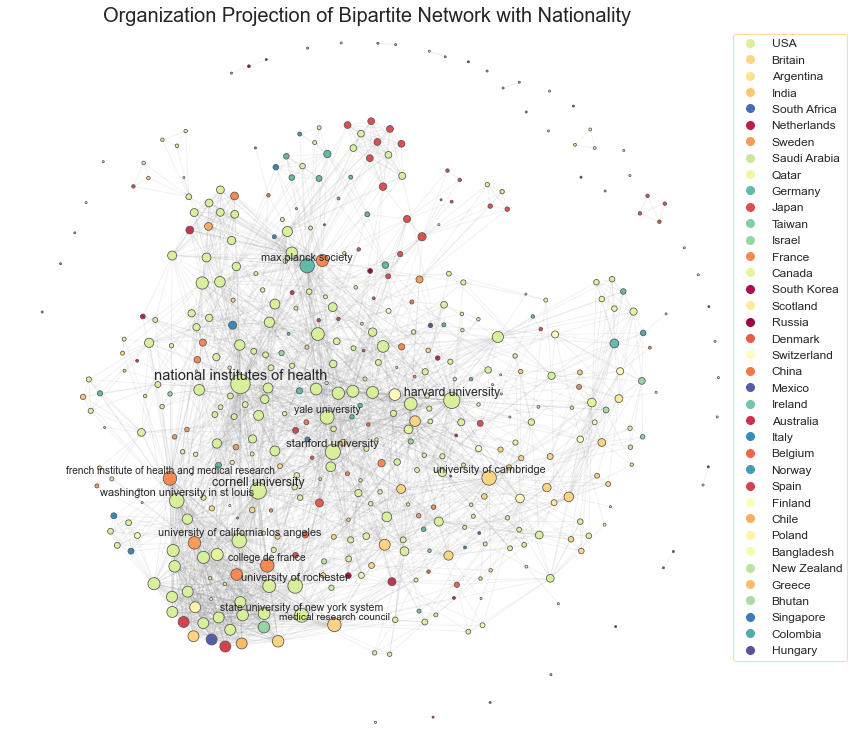

In [118]:
network = redefine_attr(network, nat_dict) # colormap it
fig, ax = nw.draw_netwulf(network, figsize = 10)
ax.set_title('Organization Projection of Bipartite Network with Nationality', size = 20)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>10: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 8)
# Place legend
legend = plt.legend(bbox_to_anchor = (1,1.0), fontsize = 12, frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
fig.tight_layout()
plt.savefig('Plots/university_projection_nationality.png', dpi=200, bbox_inches='tight')

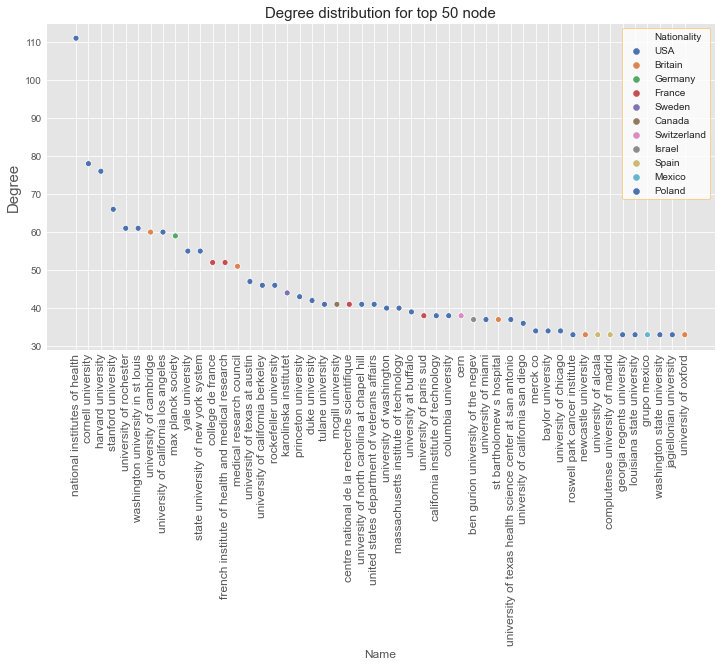

In [119]:
f = plot_top_nodes(G=G_bottom_pro,
                   hue_name = 'Nationality',
                   hue_dict = nat_dict)

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
f.savefig('Plots/top_connected_university_bipart.png', dpi=None, facecolor='w', edgecolor='w',
         bbox_inches="tight")

# Community detection 

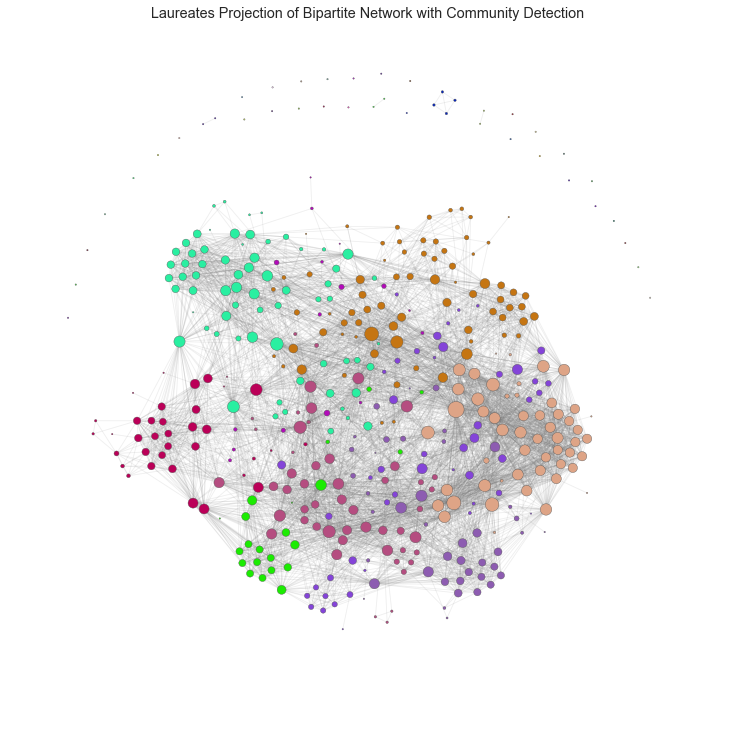

In [120]:
import community
import netwulf as nw
#Detect communities with louvrain modularity
partitions = community.best_partition(G_top_pro)
# Assign communty labels
nx.set_node_attributes(G_top_pro, partitions, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Laureates Projection of Bipartite Network with Community Detection')
plt.show()

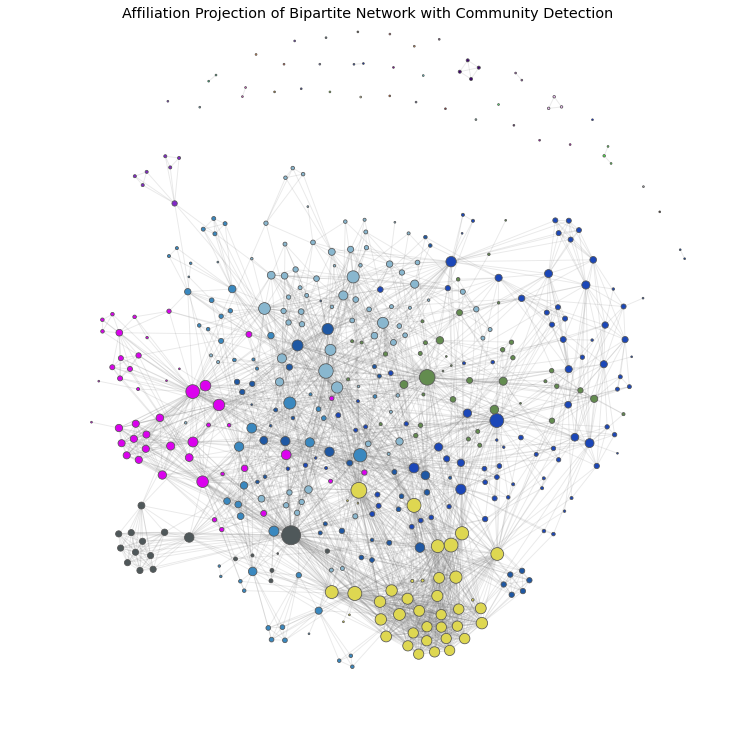

In [60]:
#Detect communities with louvrain modularity
partitions = community.best_partition(G_bottom_pro)
# Assign communty labels
nx.set_node_attributes(G_bottom_pro, partitions, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Affiliation Projection of Bipartite Network with Community Detection')
plt.show()